**File:** MLPStock.ipynb

**Mark Oliver
**Adapted from the LinkedIn Course: Data Science Foundations: Data Mining in Python file MLP.ipynb and from
**https://medium.com/@Matthew_Frank/stock-price-prediction-using-transformers-2d84341ff213
**file StockPricePredictionUsingTransformers.ipynb
**https://colab.research.google.com/drive/1j3AYSIxhiNJSCP692pKPbLk4_-kG4Pmh?usp=sharing

# IMPORT LIBRARIES

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')
import itertools
from itertools import product

In [ ]:
def calculate_bollinger_bands(data, window=10, num_of_std=2):
    """Calculate Bollinger Bands"""
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, lower_band

def calculate_rsi(data, window=10):
    """Calculate Relative Strength Index"""
    delta = data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_roc(data, periods=10):
    """Calculate Rate of Change."""
    roc = ((data - data.shift(periods)) / data.shift(periods)) * 100
    return roc

In [ ]:
tickers = ["AAPL", "MSFT", "AMZN", "NVDA", "TSLA", "GOOG", "GOOGL",  "BRK-B","META",\
          "UNH", "V", "XOM", "JPM", "JNJ", "WMT", "MA", "PG", "CVX", "HD", "LLY", "ABBV", \
         "BAC", "MRK", "AVGO", "KO", "ORCL", "PEP", "PFE", "TMO", "COST", "QQQ", "CRWD", "TTD"]

In [ ]:
print(len(tickers))

33


In [ ]:
yf.Ticker('BRK_B')

yfinance.Ticker object <BRK_B>

In [ ]:
tdata = yf.download("BRK-B", period="1mo", interval="2m")

[*********************100%***********************]  1 of 1 completed


In [ ]:
tdata.shape

(4092, 6)

In [ ]:
tdata.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-10-07 09:30:00-04:00,462.339996,462.339996,459.769104,459.769104,459.769104,161738
2024-10-07 09:32:00-04:00,459.622803,461.119995,459.200195,460.684998,460.684998,31800
2024-10-07 09:34:00-04:00,460.694885,460.695007,458.929993,460.329987,460.329987,35316
2024-10-07 09:36:00-04:00,460.299988,460.299988,458.880005,459.959991,459.959991,18557
2024-10-07 09:38:00-04:00,459.799988,459.799988,458.709991,458.845001,458.845001,23430


In [ ]:
ticker_data_frames = []
stats = {}
for ticker in tickers:

    # Download historical data for the ticker
    data = yf.download(ticker, period="1mo", interval="2m")

    # Calculate the daily percentage change
    close = data['Close']
    upper, lower = calculate_bollinger_bands(close, window=14, num_of_std=2)
    width = upper - lower
    rsi = calculate_rsi(close, window=14)
    roc = calculate_roc(close, periods=14)
    volume = data['Volume']
    diff = data['Close'].diff(1)
    percent_change_close = data['Close'].pct_change() * 100

    # Create a DataFrame for the current ticker and append it to the list
    ticker_df = pd.DataFrame({
        ticker+'_close': close,
        ticker+'_width': width,
        ticker+'_rsi': rsi,
        ticker+'_roc': roc,
        ticker+'_volume': volume,
        ticker+'_diff': diff,
        ticker+'_percent_change_close': percent_change_close,
    })

    MEAN = ticker_df.mean()
    STD = ticker_df.std()

    # Keep track of mean and std
    for column in MEAN.index:
      stats[f"{column}_mean"] = MEAN[column]
      stats[f"{column}_std"] = STD[column]

    # Normalize the training features
    ticker_df = (ticker_df - MEAN) / STD

    ticker_data_frames.append(ticker_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Convert stats from dict to df
stats = pd.DataFrame([stats], index=[0])
stats.head()

,AAPL_close_mean,AAPL_close_std,AAPL_width_mean,AAPL_width_std,AAPL_rsi_mean,AAPL_rsi_std,AAPL_roc_mean,AAPL_roc_std,AAPL_volume_mean,AAPL_volume_std,...,TTD_rsi_mean,TTD_rsi_std,TTD_roc_mean,TTD_roc_std,TTD_volume_mean,TTD_volume_std,TTD_diff_mean,TTD_diff_std,TTD_percent_change_close_mean,TTD_percent_change_close_std
0,230.092597,3.806064,0.90484,0.959809,51.69034,16.549611,0.00387,0.334957,152740.134795,249433.001848,...,51.767077,15.939781,0.036707,0.394684,9809.326954,15760.806961,0.003137,0.141969,0.002809,0.122632


In [ ]:
# Concatenate all ticker DataFrames
df = pd.concat(ticker_data_frames, axis=1)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print(df.shape)
df.head()


(3881, 231)


,AAPL_close,AAPL_width,AAPL_rsi,AAPL_roc,AAPL_volume,AAPL_diff,AAPL_percent_change_close,MSFT_close,MSFT_width,MSFT_rsi,...,CRWD_volume,CRWD_diff,CRWD_percent_change_close,TTD_close,TTD_width,TTD_rsi,TTD_roc,TTD_volume,TTD_diff,TTD_percent_change_close
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-10-07 09:58:00-04:00,-1.216057,0.066875,0.192077,0.259513,-0.050567,0.298578,0.304536,-0.655165,0.386624,-0.450473,...,0.021066,0.211990,0.223957,-2.270577,2.260860,-1.073244,-2.309589,-0.259138,2.588407,2.721711
2024-10-07 10:00:00-04:00,-1.208768,0.035707,0.702009,0.696578,0.151602,0.150963,0.153728,-0.631203,0.326259,-0.687622,...,-0.025342,-0.014603,-0.016133,-2.322332,1.925329,-0.939352,-1.903225,-0.241118,-0.849925,-0.891245
2024-10-07 10:02:00-04:00,-1.165033,0.031650,0.907233,0.954644,0.140722,0.889111,0.907319,-0.594593,0.007580,-1.030435,...,-0.135824,2.591781,2.744617,-2.207526,1.688033,-0.455623,-0.928134,-0.166185,1.860011,1.951344
2024-10-07 10:04:00-04:00,-1.138307,-0.317699,1.683952,1.552287,0.084631,0.544627,0.555177,-0.532021,-0.025249,-0.153460,...,0.287439,2.570765,2.710947,-2.046310,1.739454,0.004321,0.078583,-0.202408,2.615067,2.737129
2024-10-07 10:06:00-04:00,-1.152884,-0.268748,0.889486,0.601732,-0.120821,-0.291880,-0.298025,-0.579857,-0.054733,-0.205860,...,0.151807,-1.645083,-1.728753,-2.076500,1.337992,-0.384916,-0.790484,-0.153080,-0.499058,-0.521107


# PLOT DATA

In [ ]:
ticker_data_frames[0].head()

,AAPL_close,AAPL_width,AAPL_rsi,AAPL_roc,AAPL_volume,AAPL_diff,AAPL_percent_change_close
Datetime,,,,,,,
2024-09-26 09:30:00-04:00,-0.795976,NaN,NaN,NaN,4.357670,NaN,NaN
2024-09-26 09:35:00-04:00,-0.891211,NaN,-3.186408,NaN,0.626536,-0.997604,-1.013664
2024-09-26 09:40:00-04:00,-0.978231,NaN,-3.186408,NaN,0.578061,-0.912237,-0.928402
2024-09-26 09:45:00-04:00,-0.899371,NaN,-1.332124,NaN,0.901413,0.811672,0.825962
2024-09-26 09:50:00-04:00,-0.859902,NaN,-0.769403,NaN,0.492358,0.402306,0.408520


In [ ]:
ticker_data_frames[0]['AAPL_close'].head()

Datetime
2024-09-26 09:30:00-04:00   -0.795976
2024-09-26 09:35:00-04:00   -0.891211
2024-09-26 09:40:00-04:00   -0.978231
2024-09-26 09:45:00-04:00   -0.899371
2024-09-26 09:50:00-04:00   -0.859902
Name: AAPL_close, dtype: float64

In [ ]:
ticker_data_frames[0].shape

(1716, 7)

In [ ]:
stats = pd.DataFrame([stats], index=[0])
stats.head()

In [ ]:
stats.shape

AttributeError: 'dict' object has no attribute 'shape'

In [ ]:
for i, df in enumerate(ticker_data_frames):
    minutes = df.index.strftime("%m%d%M")
    closes = df[f'{tickers[i]}_close'].values
    dft = pd.DataFrame({'y':closes,'x':minutes})
    # df.plot(x=minutes,y=tickers[i]+'_close')
    # dft = dft.reset_index()
    dft.plot('x','y',title=tickers[i])
    # print(df[f'{tickers[i]}_close'].values.size)
    # print(minutes.values.size)
    # print(dft.head())
    # print(minutes.values)

In [ ]:
ticker_data_frames = []
stats = {}
for ticker in tickers:

    # Download historical data for the ticker
    data = yf.download(ticker, period="1mo", interval="2m")

    # Calculate the daily percentage change
    close = data['Close']
    upper, lower = calculate_bollinger_bands(close, window=14, num_of_std=2)
    width = upper - lower
    rsi = calculate_rsi(close, window=14)
    roc = calculate_roc(close, periods=14)
    volume = data['Volume']
    diff = data['Close'].diff(1)
    percent_change_close = data['Close'].pct_change() * 100

    # Create a DataFrame for the current ticker and append it to the list
    ticker_df = pd.DataFrame({
        ticker+'_close': close,
        ticker+'_width': width,
        ticker+'_rsi': rsi,
        ticker+'_roc': roc,
        ticker+'_volume': volume,
        ticker+'_diff': diff,
        ticker+'_percent_change_close': percent_change_close,
    })

    MEAN = ticker_df.mean()
    STD = ticker_df.std()

    # Keep track of mean and std
    for column in MEAN.index:
      stats[f"{column}_mean"] = MEAN[column]
      stats[f"{column}_std"] = STD[column]

    # Normalize the training features
    ticker_df = (ticker_df - MEAN) / STD

    ticker_data_frames.append(ticker_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
stats = pd.DataFrame([stats], index=[0])
stats.head()

In [ ]:
def mlp_model(X, Y):

    estimator=MLPRegressor()

    params = np.arange(10,25,1)
    jls = [(2*p,p,p) for p in params]
    param_grid = {'hidden_layer_sizes': jls,
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.001, 0.0001, 0.05],
          'learning_rate': ['constant','adaptive'],
          'solver': ['adam'],
           'batch_size':[16,32,64],
            'shuffle: [False]
                 }

    gsc = GridSearchCV(
    estimator,
    param_grid,
    cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X, Y)


    best_params = grid_result.best_params_

    best_mlp = MLPRegressor(hidden_layer_sizes = best_params["hidden_layer_sizes"],
                        activation =best_params["activation"],
                        solver=best_params["solver"],
                        max_iter= 5000, n_iter_no_change = 200
              )

    scoring = {
           'abs_error': 'neg_mean_absolute_error',
           'squared_error': 'neg_mean_squared_error',
           'r2':'r2'}

    scores = cross_validate(best_mlp, X, Y, cv=10, scoring=scoring, return_train_score=True, return_estimator = True)
return best_params, scores


- Use the mean squared error (MSE) as cross-validation loss.

In [ ]:
def cross_validation_loss(hidden_neurons, Xtrain, ytrain):

    mse = []

    for train_split_, valid_split_ in tscv.split(Xtrain):

        X_train_, y_train_ = X_train[train_split_], ytrain[train_split_]
        X_valid_, y_valid_ = X_train[valid_split_], ytrain[valid_split_]

        mlp = MLPRegressor(hidden_layer_sizes=(2*hidden_neurons,hidden_neurons, hidden_neurons,), max_iter=5000,
                           activation='relu', optimizer='RMSProp', learning_rate_init=0.001, alpha=0.00001, random_state=1, shuffle=False)

        mlp.fit(X_train_, y_train_)

        mse.append(mean_squared_error(y_valid_, mlp.predict(X_valid_)))

    return np.mean(mse)

In [ ]:
k = 5
total_mse = 0
scores = []
for i,odf in enumerate(ticker_data_frames):
    columns = list(odf.columns.values)
    newColumns = columns[1:k]
    newColumns.append(columns[0])
    df = odf[newColumns]
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df = df.iloc[:-1]
    # print(df.head())
    Z = df.to_numpy()
    split = np.int32(0.8 * Z.shape[0])
    Z_train, Z_test = Z[:split, :], Z[split:, :]
    scaler = StandardScaler().fit(Z_train)
    Z_train = scaler.transform(Z_train)
    Z_test = scaler.transform(Z_test)
    X_train, y_train = Z_train[:, :-1], Z_train[:, -1]
    X_test, y_test = Z_test[:, :-1], Z_test[:, -1]
    params, errors = mlp_model(X_train, y_train)
    mlp = MLPRegressor(hidden_layer_sizes = params["hidden_layer_sizes"],
                    activation =params["activation"],
                    solver=params["solver"],
                    max_iter= 5000, n_iter_no_change = 200

    # params = [10,15, 16, 17, 18, 19 ,20,21,22,23,24,25,30,35,40,45,50,55,60,65,75]
    # params = np.arange(10,25,1)
    # mse = [cross_validation_loss(p, X_train,y_train) for p in params]
    # minMSE = params[np.argmin(mse)]
    # mlp = MLPRegressor(hidden_layer_sizes=(2*minMSE,minMSE,minMSE,), max_iter=5000, random_state=1,
    #                    activation='relu', learning_rate_init=0.001, alpha=0.00001,shuffle=False)
    print(f'minMSE: {minMSE}  df.shape {df.shape} {stats.iloc[0][0:2]} {stats.iloc[0][0]}    {stats.iloc[0][1]}')
    mean_close =stats.iloc[0][0]
    mean_std = stats.iloc[0][1]
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    y_test_ = (scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1] * mean_std) + mean_close
    y_pred_ = (scaler.inverse_transform(np.hstack([X_test, y_pred.reshape(-1, 1)]))[:, -1] * mean_std) + mean_close
    mse_ = mean_squared_error(y_test_, y_pred_)
    total_mse += mse_
    print(f'mean squared error {mse_}')
    fig, ax = plt.subplots()
    plt.xlabel(tickers[i])
    plt.ylabel(f'{tickers[i]} close')
    plt.title(f'2 minute {tickers[i]}')
    # plt.plot(df[f'{tickers[i]}_close'], color='black', label='Training Data')
    plt.plot(pd.Series(y_test_, index=odf.index[-len(y_test):]), color='blue', label='Test Data')
    plt.plot(pd.Series(y_pred_, index=odf.index[-len(y_test):]), color='red', label=f'Forecast {tickers[i]}')
    plt.legend(bbox_to_anchor=(1.05, 1))
    ax.xaxis.set_major_formatter(DateFormatter('%D'))
    plt.show()
    # break
print(total_mse)

TypeError: MLPRegressor.__init__() got an unexpected keyword argument 'optimizer'

- Calculate the cross validation loss corresponding to different numbers of hidden nodes.

In [ ]:
params = [10,15,20,25,30,35,40,45,50,55,60,65,75]
mse = [cross_validation_loss(p) for p in params]

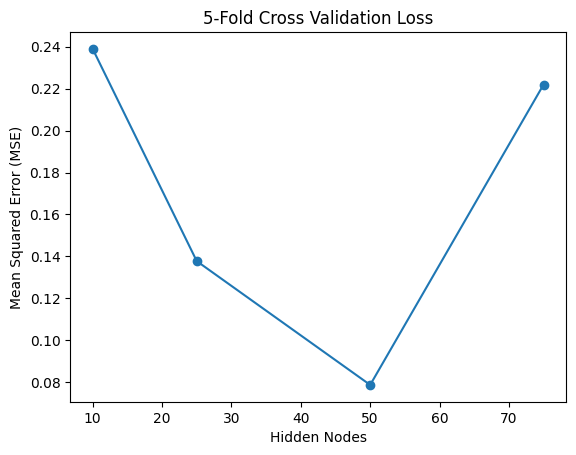

In [ ]:
fig, ax = plt.subplots()
plt.xlabel('Hidden Nodes')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('5-Fold Cross Validation Loss')
plt.plot(params, mse, '-o')

- Find the number of hidden nodes associated with the smallest cross validation loss.

In [ ]:
params[np.argmin(mse)]

50

In [ ]:
y_train

array([-1.5670949 , -1.44568393, -1.28012353, -1.34634769, -1.45672129,
       -1.19182465, -0.96004009, -0.96004009, -1.09248841, -1.36842241,
       -1.57813226, -1.29116089, -1.23597409, -1.18078729, -0.87174121,
       -1.03730161, -0.93796537, -0.87174121, -0.63995665, -0.63995665,
       -0.80551705, -1.04833897, -1.22493673, -1.00418953, -0.94900273,
       -0.84966649, -0.70618081, -0.83862913, -0.81655441, -0.43024681,
       -0.29779849, -0.16535017, -0.52958305, -0.72825553, -0.93796537,
       -0.69514345, -0.67306873, -0.67306873, -0.23157433, -0.24261169,
       -0.30883585, -0.15431281,  0.07747176,  0.16577064, -0.22053697,
       -0.50750833, -0.84966649, -0.61788193, -0.58476985, -0.76136761,
       -0.24261169, -0.33091057, -0.25364905,  0.07747176,  0.49689144,
        0.3975552 ,  0.02228496, -0.30883585, -0.59580721, -0.30883585,
       -0.16535017, -0.26468641,  0.11058384,  0.13265856,  0.14369592,
        0.64037712,  1.18120776,  0.99357264,  0.60726504,  0.18

- Fit an MLP model with 50 hidden nodes to the training data.

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=1, shuffle=False)

In [ ]:
mlp.fit(X_train, y_train)

- Use the fitted MLP model to forecast the test data.

In [ ]:
y_pred = mlp.predict(X_test)

- Transform the data back to the original scale.

In [ ]:
y_test_ = scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1]
y_pred_ = scaler.inverse_transform(np.hstack([X_test, y_pred.reshape(-1, 1)]))[:, -1]

- Plot the data and the forecasts in the original scale.

In [ ]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(df.iloc[:(k + len(y_train) + 1), :], color='black', label='Training Data')
plt.plot(pd.Series(y_test_, index=df.index[-len(y_test):]), color='blue', label='Test Data')
plt.plot(pd.Series(y_pred_, index=df.index[-len(y_test):]), color='red', label='Forecast (50 hidden nodes)')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# CLEAN UP

- If desired, clear the results with Cell > All Output > Clear.
- Save your work by selecting File > Save and Checkpoint.
- Shut down the Python kernel and close the file by selecting File > Close and Halt.